In [ ]:
%cd "/gscratch/xlab/alisaliu/superbpe"

/mmfs1/gscratch/xlab/alisaliu/pretokenization


/gscratch/cse/alisaliu/miniconda3/envs/playground/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import json
import re
import os
from pathlib import Path
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from utils import read_json
import plot_utils
from plot_utils import GradientHandler

In [3]:
def get_results(config=None, tokenizer_dir=None, eval_dataset=None):
    if config:
        if config['pretok_setting'] == 'pretok':
            tokenizer_dir = Path(f"tokenizer_json/{config['train_dataset']}_{config['pretok_setting']}_{config['train_size']}_{config['vocab_size']}")
        elif config['pretok_setting'] == 'nopretok':
            tokenizer_dir = Path(f"tokenizer_json/{config['train_dataset']}_{config['pretok_setting']}_{config['train_size']}_{config['vocab_size']}_mw{config['max_multiword']}_colon")
        elif config['pretok_setting'] == 'extend':
            tokenizer_dir = Path(f"tokenizer_json/{config['train_dataset']}_{config['train_size']}_{config['num_inherit']}_extend_{config['vocab_size']}_mw{config['max_multiword']}_colon")
        eval_dataset = config['eval_dataset']
        print(tokenizer_dir)
    elif tokenizer_dir and eval_dataset:
        tokenizer_dir = Path(tokenizer_dir)
    else:
        print('Need either config or both tokenizer_dir and eval_dataset.')
        return None
    
    results = {}
    for filename in os.listdir(tokenizer_dir / eval_dataset):
        if filename.startswith('token_byte_counts'):
            match = re.search(r'\d+', filename)
            if match:
                vocab_size = int(match.group())
            else:
                vocab_size = len(read_json(tokenizer_dir / 'tokenizer.json')['model']['vocab'])
            
            token_byte_counts = read_json(tokenizer_dir / eval_dataset / filename)
            bytes_per_token = token_byte_counts['byte_count'] / token_byte_counts['token_count']
        elif filename == 'pretoken_byte_counts.json':
            token_byte_counts = read_json(tokenizer_dir / eval_dataset / filename)
            bytes_per_token = token_byte_counts['byte_count'] / token_byte_counts['pretoken_count']
            vocab_size = float('inf')
        
        results[vocab_size] = bytes_per_token
        
    return results

In [4]:
eval_dataset_name = 'olmo2'
vocab_size = '200K'
train_dataset_name = f'olmo2_p99_truncate'

compare_config = [{
    'train_dataset': train_dataset_name,
    'train_size': '10G',
    'pretok_setting': 'nopretok',
    'eval_dataset': eval_dataset_name,
    'vocab_size': vocab_size,
    'max_multiword': 4
}]

# find transition points based on directory names
transition_points = []
for dirname in os.listdir('tokenizer_json'):
    match = re.match(rf'{train_dataset_name}_10G_(\d+)K_extend_{vocab_size}_mw4_colon', dirname)
    if match:
        num_inherit = int(match.group(1))
        transition_points.append(num_inherit)

# add a config for each transition point
transition_points.sort()
for num_inherit in transition_points:
    compare_config.append({
        'train_dataset': train_dataset_name,
        'train_size': '10G',
        'pretok_setting': 'extend',
        'num_inherit': f'{num_inherit}K',
        'eval_dataset': eval_dataset_name,
        'vocab_size': vocab_size,
        'max_multiword': 4
    })

compare_config.append(
    {
        'train_dataset': train_dataset_name,
        'train_size': '10G',
        'pretok_setting': 'pretok',
        'eval_dataset': eval_dataset_name,
        'vocab_size': vocab_size
    }
)

In [5]:
# read results
results = {}
for config in compare_config:
    if config['pretok_setting'] == 'extend':
        label = f"curriculum ({config['num_inherit']})"
    else:
        label = config['pretok_setting']
    
    results[label] = get_results(config)

tokenizer_json/olmo2_p99_truncate_nopretok_10G_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_20K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_40K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_60K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_80K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_100K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_120K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_140K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_160K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_10G_180K_extend_200K_mw4_colon
tokenizer_json/olmo2_p99_truncate_pretok_10G_200K


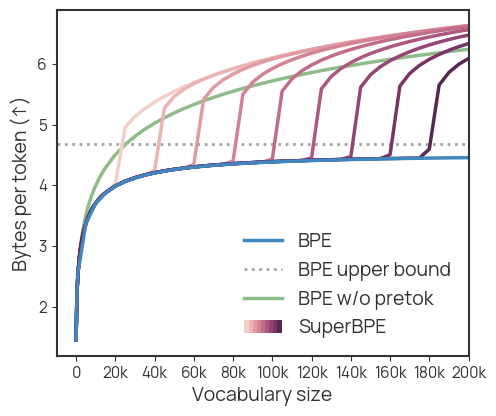

In [6]:
from matplotlib.colors import ListedColormap
from matplotlib.legend_handler import HandlerBase

fig, ax = plt.subplots(figsize=(4.8, 4))
legend_handles = [None] * 4
legend_labels = [""] * 4
curriculum_colors = []

upper_bound = results['pretok'][float('inf')]
ax.axhline(y=upper_bound, ls='dotted', color=sns.color_palette('deep')[-3], alpha=0.8, linewidth=2)

for i, (label, result) in enumerate(results.items()):
    if 'curriculum' in label:
        color = sns.cubehelix_palette(start=3.26, n_colors=len(results)-1, rot=0.3, hue=1.0)[i-1]
        curriculum_colors.append(color)
    elif label == 'pretok':
        color = "#4086BF"
    elif label == 'nopretok':
        color = "#8FBC8B"
    
    plot = sns.lineplot(result, color=color, label=label, ax=ax, linewidth=2.5)
    
    if 'curriculum' not in label:        
        if label == 'pretok':
            legend_handles[0] = plot.get_lines()[-1]
            legend_labels[0] = "BPE"
        elif label == 'nopretok':
            legend_handles[2] = plot.get_lines()[-1]
            legend_labels[2] = "BPE w/o pretok"

cmap = ListedColormap(curriculum_colors)

# Create dummy patch for gradient legend entry
gradient_patch = mpatches.Patch(facecolor='none', edgecolor='none', linewidth=0)
legend_handles[-1] = gradient_patch
legend_labels[-1] = 'SuperBPE'

legend_handles[1] = plot.get_lines()[0]
legend_labels[1] = 'BPE upper bound'

# Create legend with custom handler
ax.legend(
    handles=legend_handles,
    labels=legend_labels,
    handler_map={mpatches.Patch: GradientHandler(cmap, num_stripes=20)},
    fontsize=14,
    frameon=False
)
# plot.set_xscale('log')

# xticks
xticks = range(0, 200001, 20000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

ax.set_xlim(right=200000)

ax.set_xlabel('Vocabulary size')
ax.set_ylabel('Bytes per token (↑)')
plt.tight_layout(pad=0.1)
plt.savefig('plots/pretokenization_scaling.png', dpi=300)
plt.savefig('plots/pretokenization_scaling.pdf', dpi=300)

In [7]:
vocab_size=200000
for key in results:
    if vocab_size in results[key]:
        print(f'{key}: {results[key][vocab_size]}')

nopretok: 6.243093421824771
curriculum (20K): 6.610424339069447
curriculum (40K): 6.627940845521906
curriculum (60K): 6.633993188773049
curriculum (80K): 6.6340211791656865
curriculum (100K): 6.618049635756115
curriculum (120K): 6.566714270967322
curriculum (140K): 6.477883269243099
curriculum (160K): 6.337087825510061
curriculum (180K): 6.092017425484803
pretok: 4.4565498996817245


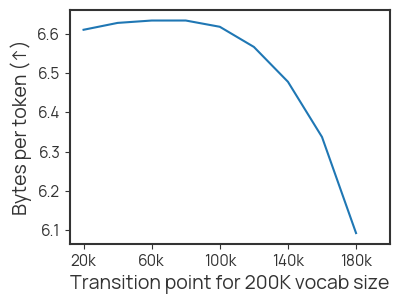

In [8]:
x, y = [], []

for key in results:
    if key.startswith('curriculum'):
        if vocab_size in results[key]:
            x.append(int(key.split('(')[-1].split(')')[0].replace('K', '000')))
            y.append(results[key][vocab_size])

fig, ax = plt.subplots(figsize=(6.4*3/5, 4.8*3/5))
sns.lineplot(x=x, y=y)
ax.set_xlim(right=vocab_size)

xticks = range(20000, vocab_size, 40000)
ax.set_xticks(xticks)
ax.set_xticklabels([f"{tick//1000}k" if tick != 0 else "0" for tick in xticks])

ax.set_xlabel(f'Transition point for {vocab_size // 1000}K vocab size')
ax.set_ylabel('Bytes per token (↑)')
plt.tight_layout(pad=0.1)
plt.savefig('plots/transition_point.png', dpi=300)
plt.savefig('plots/transition_point.pdf', dpi=300)